<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombre:** José Fernando Flores.

**Fecha:** 13 de mayo del 2020.

**Expediente** : 714575.
**Profesor:** Oscar David Jaramillo Zuluaga.

# Tarea 11: Clase 23

### Ejercicio 1: 

> Implementar el método de esquemas del trapecio, para valuar la opción call y put asiática con precio inicial, $S_0 = 100$, precio de ejercicio $K = 100$, tasa libre de riesgo $r = 0.10$, volatilidad $\sigma = 0.20$ y $T = 1$ año. Cuyo precio es $\approx 7.04$. Realizar la simulación en base a la siguiente tabla:
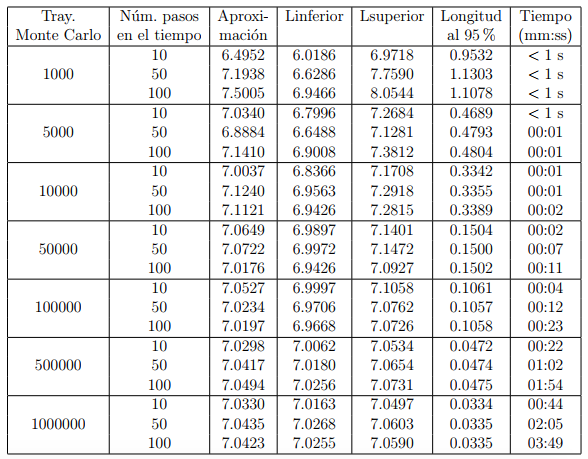

> Observe que en esta tabla se encuentran los intervalos de confianza de la aproximación obtenida y además el tiempo de simulación que tarda en encontrar la respuesta cada método. 
- Se debe entonces realizar una simulación para la misma cantidad de trayectorias y número de pasos y construir una Dataframe de pandas para reportar todos los resultados obtenidos.**(70 puntos)**
- Compare los resultados obtenidos con los resultados arrojados por la función `Riemann_approach`. Concluya. **(30 puntos)**

In [1]:

#Código de solución
#Importar paquetes
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import time
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 9)
pd.set_option('display.max_rows', 22)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
def BSprices(mu,sigma,S0,NbTraj,NbStep):
    """
    Expresión de la solución de la ecuación de Black-Scholes
    St = S0*exp((r-sigma^2/2)*t+ sigma*DeltaW)
    
    Parámetros
    ---------
    mu    : Tasa libre de riesgo
    sigma : Desviación estándar de los rendimientos
    S0    : Precio inicial del activo subyacente
    NbTraj: Cantidad de trayectorias a simular
    NbStep: Número de días a simular
    """
    # Datos para la fórmula de St
    nu = mu-(sigma**2)/2
    DeltaT = 1/NbStep
    SqDeltaT = np.sqrt(DeltaT)
    DeltaW = SqDeltaT*np.random.randn(NbTraj,NbStep-1)
    
    # Se obtiene --> Ln St = Ln S0+ nu*DeltaT + sigma*DeltaW
    increments = nu*DeltaT + sigma*DeltaW
    concat = np.concatenate((np.log(S0)*np.ones([NbTraj,1]),increments),axis=1)
    
    # Se utiliza cumsum por que se quiere simular los precios iniciando desde S0
    LogSt = np.cumsum(concat,axis=1)
    # Se obtienen los precios simulados para los NbStep fijados
    St = np.exp(LogSt)
    # Vector con la cantidad de días simulados
    t = np.arange(0,NbStep)

    return St.T,t

def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

In [3]:
def Riemann_approach(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',tipo:'call o put',
                    flag=None):
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Obtenemos los precios promedios
    Average_t = prices.expanding().mean()
    # Definimos el dataframe de strikes
    strike = pd.DataFrame(K*np.ones([NbStep,NbTraj]), index=t)
    if tipo=='call':
        # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
        call = pd.DataFrame({'Prima':np.exp(-r*T) \
                     *np.fmax(Average_t-strike,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
        # intervalos de confianza
        confianza = 0.95
        sigma_est = call.sem().Prima
        mean_est = call.iloc[-1].Prima
        i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
        return call.iloc[-1].Prima, i1
    elif tipo=='put':
        put = pd.DataFrame({'Prima':np.exp(-r*T) \
                 *np.fmax(strike-Average_t,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
        # intervalos de confianza
        confianza = 0.95
        sigma_est = put.sem().Prima
        mean_est = put.iloc[-1].Prima
        i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
        return put.iloc[-1].Prima, i1

Desarrollando la exponencial en serie de taylor y suponiendo que $h$ es pequeña, sólo se conservan los términos de orden uno, se tiene la siguiente aproximación:
$$\int_0^T S_u du \approx {h \over 2}\sum_{i=0}^{N-1}S_{t_i}(2+rh+(W_{t_{i+1}}-W_{t_i})\sigma)$$

Reemplazando esta aproximación en el precio del call, se tiene la siguiente estimación:
$$\hat V_0^{(2)}= {e^{-rT} \over M} \sum_{j=1}^{M} \Bigg({h\over 2T} \sum_{i=0}^{N-1} S_{t_i}(2+rh+(W_{t_{i+1}}-W_{t_i})\sigma)-K \Bigg)_+$$
**recordar que $h = \frac{T}{N}$**
> **Referencia**:
http://mat.izt.uam.mx/mat/documentos/notas%20de%20clase/cfenaoe3.pdf

In [4]:
def Riemann_approach2(K:'Strike price',r:'Tasa libre de riesgo',S0:'Precio inicial',
                     NbTraj:'Número trayectorias',NbStep:'Cantidad de pasos a simular',
                     sigma:'Volatilidad',T:'Tiempo de cierre del contrato en años',tipo:'call o put',
                    flag=None):
    # Resolvemos la ecuación de black scholes para obtener los precios
    St,t = BSprices(r,sigma,S0,NbTraj,NbStep)
    # Almacenamos los precios en un dataframe
    prices = pd.DataFrame(St,index=t)
    # Creamos el segundo DataFrame
    mult= pd.DataFrame(2+r*(T/NbStep)+np.random.randn(NbTraj,NbStep)*sigma).T
    # Multiplicamos los dataframes
    prices_mult= prices*mult
    # Hacemos la sumatoria
    sumprices_mult = np.cumsum(prices_mult)
    # Multiplicamos por h/2 
    sumatoria = sumprices_mult*(1/NbStep)*(1/2)*(1/T)
    # Definimos el dataframe de strikes
    strike = pd.DataFrame(K*np.ones([NbStep,NbTraj]), index=t)
    if tipo=='call':
        # Calculamos el call de la opción según la formula obtenida para Sumas de Riemann
        call = pd.DataFrame({'Prima':np.exp(-r*T)*np.fmax(sumatoria-strike,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
        # intervalos de confianza
        confianza = 0.95
        sigma_est = call.sem().Prima
        mean_est = call.iloc[-1].Prima
        i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
        return call.iloc[-1].Prima, i1
    elif tipo=='put':
        put = pd.DataFrame({'Prima':np.exp(-r*T)*np.fmax(strike-sumatoria,np.zeros([NbStep,NbTraj])).mean(axis=1)}, index=t)
        # intervalos de confianza
        confianza = 0.95
        sigma_est = put.sem().Prima
        mean_est = put.iloc[-1].Prima
        i1 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
        return put.iloc[-1].Prima, i1

In [5]:
traj = np.array([1000,50000,10000,50000,100000,500000,1000000])


## Riemann approach mediante trapecio

In [6]:
%%timeit
NbTraj = [traj[0]] #trayectorias
NbStep = [10,50,100] #pasos
S0 = 100 #valor inicial
r = 0.10 #risk free
sigma = 0.2 #vol
K = 100 #strike price
T = 1 #tiempo en años
m1 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,'call'),
                                   NbStep)),
                                   NbTraj))


2.03 s ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%%timeit
NbTraj = 5000 #trayectorias
NbStep = [10,50,100] #pasos
S0 = 100 #valor inicial
r = 0.10 #risk free
sigma = 0.2 #vol
K = 100 #strike price
T = 1 #tiempo en años
m2 = list(map(lambda N_ste:Riemann_approach2(K,r,S0,NbTraj,N_ste,sigma,T,'call'),
                                   NbStep))


18.8 s ± 1.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%%timeit
NbTraj = 10000 #trayectorias
m3 = list(map(lambda N_ste:Riemann_approach2(K,r,S0,NbTraj,N_ste,sigma,T,'call'),
                                   NbStep))


41.2 s ± 3.94 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
NbTraj = [traj[3]] #trayectorias
NbStep = [10,50,100] #pasos
S0 = 100 #valor inicial
r = 0.10 #risk free
sigma = 0.2 #vol
K = 100 #strike price
T = 1 #tiempo en años
m4 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,'call'),
                                   NbStep)),
                                   NbTraj))


In [ ]:
%%timeit
NbTraj = [traj[4]] #trayectorias
NbStep = [10,50,100] #pasos
S0 = 100 #valor inicial
r = 0.10 #risk free
sigma = 0.2 #vol
K = 100 #strike price
T = 1 #tiempo en años
m5 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,'call'),
                                   NbStep)),
                                   NbTraj))


In [ ]:
%%timeit
NbTraj = [traj[5]] #trayectorias
NbStep = [10,50,100] #pasos
S0 = 100 #valor inicial
r = 0.10 #risk free
sigma = 0.2 #vol
K = 100 #strike price
T = 1 #tiempo en años
m6 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,'call'),
                                   NbStep)),
                                   NbTraj))


In [ ]:
%%timeit
NbTraj = [traj[6]] #trayectorias
NbStep = [10,50,100] #pasos
S0 = 100 #valor inicial
r = 0.10 #risk free
sigma = 0.2 #vol
K = 100 #strike price
T = 1 #tiempo en años
m7 = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,'call'),
                                   NbStep)),
                                   NbTraj))


**Loop completo**

In [7]:
NbTraj = traj #trayectorias
NbStep = [10,50,100] #pasos
S0 = 100 #valor inicial
r = 0.10 #risk free
sigma = 0.2 #vol
K = 100 #strike price
T = 1 #tiempo en años
mc = list(map(lambda N_tra:list(map(lambda N_ste:Riemann_approach2(K,r,S0,N_tra,N_ste,sigma,T,'call'),
                                   NbStep)),
                                   NbTraj))

In [8]:
mc

[[(6.481197485915958, (5.212693804603239, 7.749701167228677)),
  (7.344702076344615, (6.908267985059142, 7.781136167630088)),
  (7.799438695298099, (7.487178100069193, 8.111699290527007))],
 [(6.863355684398284, (5.517242977357083, 8.209468391439486)),
  (7.003925461131547, (6.590611419486175, 7.417239502776919)),
  (7.011410975134575, (6.735532752546543, 7.287289197722606))],
 [(7.111297457647292, (5.7157544691470115, 8.506840446147573)),
  (6.9624766664311215, (6.552241462105014, 7.372711870757229)),
  (7.075949636758373, (6.797772853297395, 7.354126420219351))],
 [(6.863010332869821, (5.516862134467923, 8.209158531271719)),
  (6.94263363889205, (6.53294834708383, 7.35231893070027)),
  (7.056881136536123, (6.779359693335587, 7.3344025797366585))],
 [(6.922822536898984, (5.565027403869167, 8.280617669928802)),
  (6.993459689694415, (6.580664535070048, 7.406254844318782)),
  (7.006012452365508, (6.730521961460566, 7.28150294327045))],
 [(6.891748688177362, (5.540047286780931, 8.2434500